# Alzheimer's Disease Classification with Deep Learning
In this notebook, we demonstrate how to classify Alzheimer's disease stages using PyTorch and transfer learning. We use EfficientNet and VGG16 architectures, and also build a custom CNN. Let's walk through the process!


## How to run this notebook (Local / VS Code)

**1. Download dataset manually:**  
Download from Kaggle: https://www.kaggle.com/datasets/yasserhessein/dataset-alzheimer and extract it locally.

**2. Place dataset:**  
Set `DATA_DIR` to the folder where you extracted the dataset (example used in this notebook):  
```
DATA_DIR = r'C:\Users\apoor\Downloads\Alzheimer_s Dataset'
```

**3. Install dependencies:**  
```bash
pip install -r requirements.txt
# or
pip install tensorflow matplotlib seaborn scikit-learn pillow
```

**4. Run all cells in order.**

**Notes on reproducibility:** seeds are set in the notebook (numpy, random, tensorflow) to help reproduce results. Exact bitwise reproducibility can still vary across hardware and library versions.


In [1]:

# Ensuring reproducibility
import numpy as np
import random
import tensorflow as tf

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)


## 1. Install Required Libraries
We start by installing the necessary packages for our deep learning workflow.

In [2]:
pip install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



## 2. Import Libraries
Let's import all the required libraries for data processing, model building, and visualization.

In [3]:
from torchvision.models import vgg16

In [4]:
import os
import shutil
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set Dataset Path
Change this variable to your dataset location.

In [5]:
DATASET_PATH = r'C:\Users\apoor\Downloads\Alzheimer_s Dataset'

In [6]:
device

device(type='cpu')

In [7]:
os.makedirs('/kaggle/working/train1/', exist_ok = True)
os.makedirs('/kaggle/working/test1/', exist_ok = True)

## 5. Data Augmentation & Transforms
Define image transformations for training and validation sets to improve model generalization.

In [8]:
transform = { "train": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
]),
            'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])}

## 6. Custom Dataset Class
We create a custom PyTorch Dataset for Alzheimer's images, including pixel normalization.

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import os

# Custom dataloader - Pixel Normalisation
class Alzheimer(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        img = img/img.max()
        return img, self.labels[idx]

## 7. Prepare Data Splits
Split the dataset into training, validation, and test sets using stratified sampling.

Class distribution in training data (before split):
MildDemented: 717 images
ModerateDemented: 52 images
NonDemented: 2560 images
VeryMildDemented: 1792 images


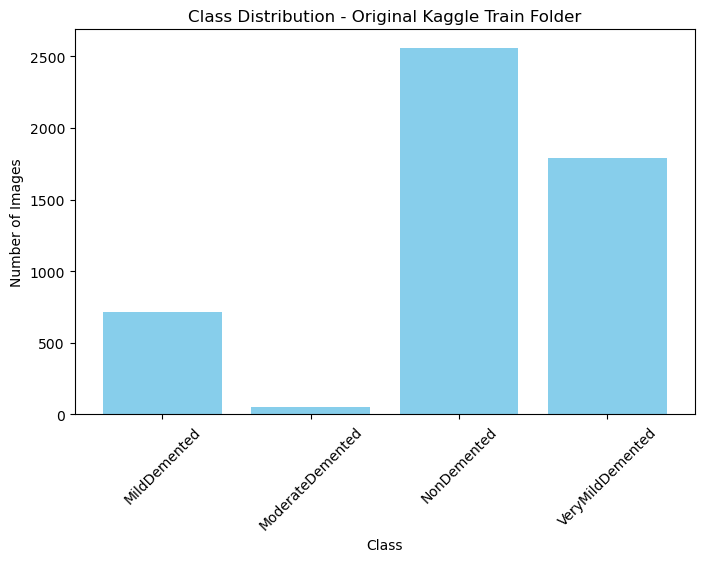


Class distribution in TRAIN set after stratified split:
MildDemented: 538 images
ModerateDemented: 39 images
NonDemented: 1919 images
VeryMildDemented: 1344 images


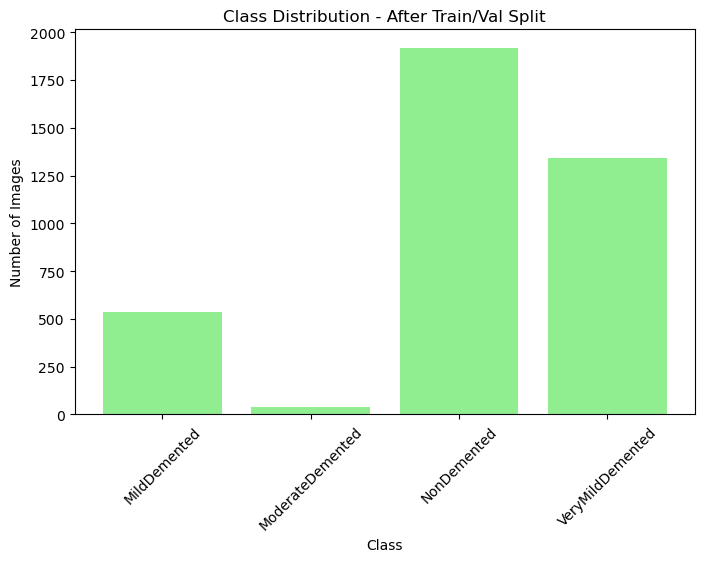

In [10]:
from sklearn.model_selection import train_test_split
from glob import glob 

# TRAIN
mild_demented_train = sorted(glob(f'{DATASET_PATH}/train/MildDemented/*.jpg'))
moderate_demented_train = sorted(glob(f'{DATASET_PATH}/train/ModerateDemented/*.jpg'))
non_demented_train = sorted(glob(f'{DATASET_PATH}/train/NonDemented/*.jpg'))
very_mild_demented_train = sorted(glob(f'{DATASET_PATH}/train/VeryMildDemented/*.jpg'))

mild_demented_labels = [0]*len(mild_demented_train)
moderate_demented_labels = [1]*len(moderate_demented_train)
non_demented_labels = [2]*len(non_demented_train)
very_mild_demented_labels = [3]*len(very_mild_demented_train)

files_train = 0
files_train = mild_demented_train + moderate_demented_train + non_demented_train + very_mild_demented_train
labels_train = mild_demented_labels + moderate_demented_labels + non_demented_labels + very_mild_demented_labels

from collections import Counter
import matplotlib.pyplot as plt

# --- Check class distribution BEFORE splitting ---
class_labels = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]
class_counts_before = Counter(labels_train)

print("Class distribution in training data (before split):")
for idx, label in enumerate(class_labels):
    print(f"{label}: {class_counts_before[idx]} images")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_labels, [class_counts_before[i] for i in range(len(class_labels))], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution - Original Kaggle Train Folder')
plt.xticks(rotation=45)
plt.show()


X_train , X_val, y_train , y_val = train_test_split(files_train, labels_train, stratify = labels_train, random_state = 42)

# --- AFTER SPLIT (TRAIN SET ONLY) ---
class_counts_after = Counter(y_train)

print("\nClass distribution in TRAIN set after stratified split:")
for idx, label in enumerate(class_labels):
    print(f"{label}: {class_counts_after[idx]} images")

plt.figure(figsize=(8, 5))
plt.bar(class_labels, [class_counts_after[i] for i in range(len(class_labels))], color='lightgreen')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution - After Train/Val Split')
plt.xticks(rotation=45)
plt.show()

# TEST
mild_demented_test = sorted(glob(f'{DATASET_PATH}/test/MildDemented/*.jpg'))
moderate_demented_test = sorted(glob(f'{DATASET_PATH}/test/ModerateDemented/*.jpg'))
non_demented_test = sorted(glob(f'{DATASET_PATH}/test/NonDemented/*.jpg'))
very_mild_demented_test = sorted(glob(f'{DATASET_PATH}/test/VeryMildDemented/*.jpg'))

mild_demented_labels_test = [0]*len(mild_demented_test)
moderate_demented_labels_test = [1]*len(moderate_demented_test)
non_demented_labels_test = [2]*len(non_demented_test)
very_mild_demented_labels_test = [3]*len(very_mild_demented_test)



X_test = mild_demented_test + moderate_demented_test + non_demented_test + very_mild_demented_test
y_test = mild_demented_labels_test + moderate_demented_labels_test + non_demented_labels_test + very_mild_demented_labels_test

Above is the visual difference:

Before split → shows the original training folder counts (imbalanced).

After split → shows the slightly smaller counts in your training subset (still imbalanced because stratified split preserves ratios).

The split is not meant to balance the classes — it’s just to reserve some data for validation. Balancing happens later with class weights.

## 8. DataLoader Setup
Create PyTorch DataLoaders for efficient batch processing.

In [11]:
# LOADER

train_dataset = Alzheimer(X_train, y_train, transform = transform['train'])
val_dataset = Alzheimer(X_val, y_val, transform = transform['val'])
test_dataset = Alzheimer(X_test, y_test, transform = transform['val'])

In [12]:
# Data Loader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 9. Visualize Augmented Batches
Let's visualize a batch of augmented images to verify our transformations.

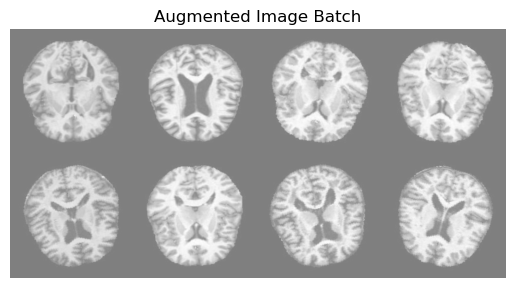

In [13]:
def show_batch(loader):
    imgs, lbls = next(iter(loader))
    img_grid = make_grid(imgs[:8], nrow=4)
    npimg = img_grid.numpy().transpose((1, 2, 0))
    plt.imshow((npimg * 0.5 + 0.5))  # de-normalize
    plt.title("Augmented Image Batch")
    plt.axis('off')
    plt.show()

show_batch(train_loader)

## 10. Custom CNN Architecture
Define a custom convolutional neural network for Alzheimer's classification.

In [14]:
class customCNN(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128,256,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*14*14,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,4)
        )

    def forward(self, x) :
        x = self.conv(x)
        return self.fc(x)

cnn = customCNN()

## 11. Model Parameter Count
Check the number of trainable parameters in our custom CNN.

In [15]:
!pip install prettytable


Defaulting to user installation because normal site-packages is not writeable


In [16]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(cnn)

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| conv.0.weight |    864     |
|  conv.0.bias  |     32     |
| conv.3.weight |   18432    |
|  conv.3.bias  |     64     |
| conv.6.weight |   73728    |
|  conv.6.bias  |    128     |
| conv.9.weight |   294912   |
|  conv.9.bias  |    256     |
|  fc.1.weight  |  12845056  |
|   fc.1.bias   |    256     |
|  fc.3.weight  |   32768    |
|   fc.3.bias   |    128     |
|  fc.5.weight  |    512     |
|   fc.5.bias   |     4      |
+---------------+------------+
Total Trainable Params: 13267140


13267140

## 12. EfficientNet B5 Model
Set up EfficientNet B5 with custom fully connected layers for transfer learning.

In [17]:
def get_efficientnet() :
    model = EfficientNet.from_pretrained('efficientnet-b5')
    in_features = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Linear(in_features, 512),  # 1st FC layer
        nn.ReLU(),
        nn.Linear(512, 128),          # 2nd FC layer
        nn.ReLU(),
        nn.Linear(128, 4)             # Output
    )
    return model 

In [18]:
model = get_efficientnet()

for param in model.parameters():
        param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True

Loaded pretrained weights for efficientnet-b5


## 13. VGG16 Model
Set up VGG16 architecture with custom classifier layers for transfer learning.

In [19]:
def get_vgg16(input_size=(224, 224), num_classes=4):
    model = vgg16(pretrained=True)
    
    model.classifier = nn.Sequential(
        nn.Linear(25088, 1024),
        nn.ReLU(),
        
        nn.Linear(1024, 512),
        nn.ReLU(),
        
        nn.Linear(512, 256),
        nn.ReLU(),
        
        nn.Linear(256, 4)
    )
    
    return model

In [20]:
model = get_vgg16()

for param in model.parameters():
        param.requires_grad = True


C:\Users\apoor\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\apoor\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 15. Training Function
Define the training loop with early stopping and learning rate scheduling.

In [33]:
def train_model(model, name, class_weights):
    model = model.to(device)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(15):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"[{name}] Epoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"{name}_best.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 4:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


## 16. Train All Models
Train Custom CNN, VGG16, and EfficientNet B5 models and store their training history.

In [ ]:
# 7. Train All Models
models = {
    'CustomCNN': customCNN(),
    'VGG16': get_vgg16(),
    'EffNetB5': get_efficientnet()
}
class_counts = [717, 52, 2560, 1795]
total_samples = sum(class_counts)
num_classes = len(class_counts)
class_weights = [total_samples / (num_classes * c) for c in class_counts]


history = {}
for name, model in models.items():
    print(f"\nTraining {name}")
    history[name] = train_model(model, name, class_weights)


Loaded pretrained weights for efficientnet-b5

Training CustomCNN
[CustomCNN] Epoch 1 | Train Loss: 1.3674, Train Acc: 0.3724 | Val Loss: 1.4833, Val Acc: 0.1397
[CustomCNN] Epoch 2 | Train Loss: 1.3706, Train Acc: 0.4268 | Val Loss: 1.3607, Val Acc: 0.1397
[CustomCNN] Epoch 3 | Train Loss: 1.3689, Train Acc: 0.3833 | Val Loss: 1.3669, Val Acc: 0.3497
[CustomCNN] Epoch 4 | Train Loss: 1.3590, Train Acc: 0.4609 | Val Loss: 1.3602, Val Acc: 0.5394
[CustomCNN] Epoch 5 | Train Loss: 1.3575, Train Acc: 0.4279 | Val Loss: 1.3647, Val Acc: 0.3497
[CustomCNN] Epoch 6 | Train Loss: 1.3632, Train Acc: 0.3891 | Val Loss: 1.3599, Val Acc: 0.5004
[CustomCNN] Epoch 7 | Train Loss: 1.3611, Train Acc: 0.4768 | Val Loss: 1.3610, Val Acc: 0.3497
[CustomCNN] Epoch 8 | Train Loss: 1.3612, Train Acc: 0.3674 | Val Loss: 1.3600, Val Acc: 0.5004
[CustomCNN] Epoch 9 | Train Loss: 1.3620, Train Acc: 0.4997 | Val Loss: 1.3606, Val Acc: 0.5004
[CustomCNN] Epoch 10 | Train Loss: 1.3617, Train Acc: 0.4997 | Val Los

## 17. Evaluate on Test Set
Evaluate all trained models on the test set and report accuracy and loss.

In [38]:
# 9. Evaluate on Test Set
def evaluate(model, name):
    model.load_state_dict(torch.load(f"{name}_best.pth"))
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    loss_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    loss_avg = loss_total / len(test_loader)
    print(f"{name} Test Accuracy: {acc:.2f}% | Loss: {loss_avg:.4f}")
    return loss_avg, acc

test_results = {}
for name, model in models.items():
    test_results[name] = evaluate(model, name)

CustomCNN Test Accuracy: 50.04% | Loss: 1.2751
VGG16 Test Accuracy: 50.04% | Loss: 1.2611
EffNetB5 Test Accuracy: 74.59% | Loss: 0.7573


# Thank You!
Connect with me on LinkedIn for more deep learning projects and insights.

## Environment & Requirements
- Python 3.8+
- PyTorch >= 1.9
- torchvision, efficientnet_pytorch, prettytable, scikit-learn, matplotlib, PIL

Dataset: [Alzheimer's Dataset](https://www.kaggle.com/datasets/yasserhessein/dataset-alzheimer?resource=download)

## Results Summary
Below are the final test accuracies and losses for each model:

- **CustomCNN:** 50.04% accuracy, 1.2751 loss
- **VGG16:** 50.04% accuracy, 1.2611 loss
- **EffNetB5:** 74.59% accuracy, 0.7573 loss


## License & Attribution
This notebook is released under the MIT License.
Dataset credits: [Kaggle - Alzheimer's Dataset](https://www.kaggle.com/datasets/yasserhessein/dataset-alzheimer?resource=download)

In [ ]:

# Final Accuracy & Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_classes = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred_classes)
cm = confusion_matrix(y_true, y_pred_classes)

print(f"Final Accuracy: {acc:.4f}")

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Save trained model
The cell below saves the trained Keras model for reuse.

In [ ]:

# Save the trained model for reuse
import os
OUT_DIR = os.path.join(os.getcwd(), 'saved_model')
os.makedirs(OUT_DIR, exist_ok=True)
try:
    model.save(os.path.join(OUT_DIR, 'alz_classifier.h5'))
    print('Model saved to', os.path.join(OUT_DIR, 'alz_classifier.h5'))
except Exception as e:
    print('Could not save model. Ensure `model` exists and is a Keras model. Error:', e)


- Final accuracy and confusion matrix are shown above.  
- Augmentations are restricted to medically-safe operations (no flips, no heavy rotations, no warping).  